In [1]:
# Cell 1: Imports + settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import joblib

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost (optional but recommended)
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

np.random.seed(42)


In [2]:
# Cell 2: Robust download functions + index download + training tickers

def download_data(ticker: str, period="10y", interval="1d", auto_adjust=True) -> pd.DataFrame:
    """
    Robust yfinance downloader:
    - Handles missing tickers safely
    - Fixes MultiIndex columns
    - Returns empty DataFrame if download fails
    """
    try:
        df = yf.download(
            ticker,
            period=period,
            interval=interval,
            auto_adjust=auto_adjust,
            progress=False,
            threads=False
        )

        if df is None or df.empty:
            return pd.DataFrame()

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        df = df.dropna().copy()
        df.columns = [c.strip().title() for c in df.columns]
        return df

    except Exception:
        return pd.DataFrame()

def download_indexes(period="10y", interval="1d", auto_adjust=True) -> pd.DataFrame:
    nifty = download_data("^NSEI", period, interval, auto_adjust).add_prefix("NIFTY_")
    sensex = download_data("^BSESN", period, interval, auto_adjust).add_prefix("SENSEX_")

    if nifty.empty or sensex.empty:
        raise ValueError("Index download failed. Check internet or yfinance.")

    return nifty.join(sensex, how="inner")

# Correct NSE tickers
train_tickers = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS",
    "SBIN.NS", "AXISBANK.NS", "ITC.NS", "LT.NS", "BHARTIARTL.NS",
    "TITAN.NS", "SUNPHARMA.NS", "WIPRO.NS", "HCLTECH.NS", "M&M.NS",
    "PAGEIND.NS", "ADANIPORTS.NS", "NTPC.NS", "POWERGRID.NS", "ONGC.NS",
    "COALINDIA.NS", "JSWSTEEL.NS", "HINDALCO.NS", "CIPLA.NS", "BPCL.NS",
    "ULTRACEMCO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "EICHERMOT.NS", "MRF.NS"
]

index_df = download_indexes(period="10y", interval="1d", auto_adjust=True)
print("Index data shape:", index_df.shape)

stock_data_dict = {}
failed_tickers = []

for t in train_tickers:
    df_stock = download_data(t, period="10y", interval="1d", auto_adjust=True)

    # Keep only tickers with enough data for rolling windows
    if df_stock.empty or len(df_stock) < 350:
        failed_tickers.append(t)
        continue

    stock_data_dict[t] = df_stock
    print("Downloaded:", t, df_stock.shape)

print("\nTotal stocks downloaded:", len(stock_data_dict))
print("Failed tickers:", failed_tickers)


Index data shape: (2461, 10)
Downloaded: RELIANCE.NS (2473, 5)
Downloaded: TCS.NS (2473, 5)
Downloaded: INFY.NS (2473, 5)
Downloaded: HDFCBANK.NS (2473, 5)
Downloaded: ICICIBANK.NS (2473, 5)
Downloaded: SBIN.NS (2473, 5)
Downloaded: AXISBANK.NS (2473, 5)
Downloaded: ITC.NS (2473, 5)
Downloaded: LT.NS (2473, 5)
Downloaded: BHARTIARTL.NS (2473, 5)
Downloaded: TITAN.NS (2473, 5)
Downloaded: SUNPHARMA.NS (2473, 5)
Downloaded: WIPRO.NS (2473, 5)
Downloaded: HCLTECH.NS (2473, 5)
Downloaded: M&M.NS (2473, 5)
Downloaded: PAGEIND.NS (2470, 5)
Downloaded: ADANIPORTS.NS (2473, 5)
Downloaded: NTPC.NS (2473, 5)
Downloaded: POWERGRID.NS (2473, 5)
Downloaded: ONGC.NS (2473, 5)
Downloaded: COALINDIA.NS (2473, 5)
Downloaded: JSWSTEEL.NS (2473, 5)
Downloaded: HINDALCO.NS (2473, 5)
Downloaded: CIPLA.NS (2473, 5)
Downloaded: BPCL.NS (2473, 5)
Downloaded: ULTRACEMCO.NS (2473, 5)
Downloaded: BAJFINANCE.NS (2473, 5)
Downloaded: BAJAJFINSV.NS (2473, 5)
Downloaded: EICHERMOT.NS (2473, 5)
Downloaded: MRF.NS (24

In [3]:
# Cell 3: Quick EDA on a high-price stock (MRF)

sample_ticker = "MRF.NS"
if sample_ticker not in stock_data_dict:
    sample_ticker = list(stock_data_dict.keys())[0]

df_sample = stock_data_dict[sample_ticker].copy()

print("Sample ticker:", sample_ticker)
print("Shape:", df_sample.shape)
display(df_sample.head())


Sample ticker: MRF.NS
Shape: (2471, 5)


,Close,High,Low,Open,Volume
Date,,,,,
2016-01-25,35561.562500,37603.111711,34962.357936,36029.103333,28052
2016-01-27,35203.210938,35733.753039,35093.892447,35704.221012,6205
2016-01-28,35175.566406,35517.203693,34849.779521,35517.203693,10884
2016-01-29,35070.527344,35429.095523,34749.366415,35143.126941,7688
2016-02-01,33777.812500,35536.887671,33484.707007,35143.127142,7872


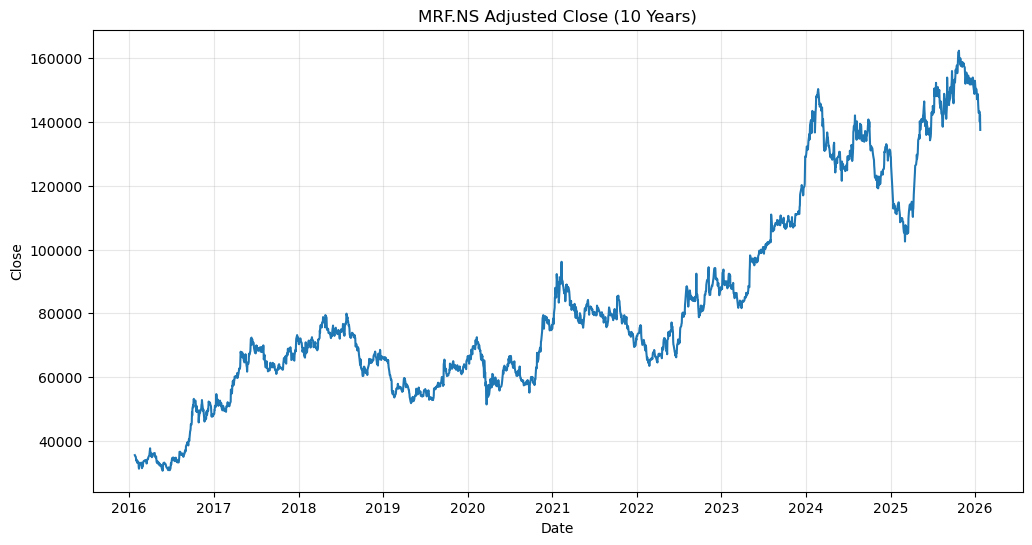

In [4]:
plt.figure(figsize=(12,6))
plt.plot(df_sample.index, df_sample["Close"])
plt.title(f"{sample_ticker} Adjusted Close (10 Years)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
# Cell 4: Feature engineering + universal target (next-day log return)

def build_features(stock_df: pd.DataFrame, index_df: pd.DataFrame, ticker_name: str) -> pd.DataFrame:
    data = stock_df.copy()
    data = data.join(index_df, how="inner")

    # Stock identity feature
    data["Ticker"] = ticker_name

    # Returns
    data["Return_1d"] = data["Close"].pct_change()
    data["LogReturn_1d"] = np.log(data["Close"] / data["Close"].shift(1))

    # Ranges
    data["HL_Range"] = data["High"] - data["Low"]
    data["OC_Range"] = data["Open"] - data["Close"]

    # Rolling features (stock)
    for w in [5, 10, 20, 50]:
        data[f"SMA_{w}"] = data["Close"].rolling(w).mean()
        data[f"EMA_{w}"] = data["Close"].ewm(span=w, adjust=False).mean()
        data[f"STD_{w}"] = data["Close"].rolling(w).std()

    # Lag features
    for lag in [1, 2, 3, 5, 10]:
        data[f"Close_Lag_{lag}"] = data["Close"].shift(lag)
        data[f"Return_Lag_{lag}"] = data["Return_1d"].shift(lag)

    # Volume features
    if "Volume" in data.columns:
        data["Vol_SMA_20"] = data["Volume"].rolling(20).mean()
        data["Vol_Ratio"] = data["Volume"] / (data["Vol_SMA_20"] + 1e-9)

    # Market context returns
    data["NIFTY_Return_1d"] = data["NIFTY_Close"].pct_change()
    data["SENSEX_Return_1d"] = data["SENSEX_Close"].pct_change()

    # Market rolling trends
    for w in [5, 10, 20]:
        data[f"NIFTY_SMA_{w}"] = data["NIFTY_Close"].rolling(w).mean()
        data[f"SENSEX_SMA_{w}"] = data["SENSEX_Close"].rolling(w).mean()

    # Relative strength vs market
    data["RelStrength_NIFTY"] = data["Return_1d"] - data["NIFTY_Return_1d"]
    data["RelStrength_SENSEX"] = data["Return_1d"] - data["SENSEX_Return_1d"]

    # Target: next-day log return (scale-free)
    data["Target_LogReturn_Next"] = data["LogReturn_1d"].shift(-1)

    # Save today's close for converting log return -> close later
    data["Close_Today"] = data["Close"]

    data.dropna(inplace=True)
    return data

all_data = []
for tkr, sdf in stock_data_dict.items():
    all_data.append(build_features(sdf, index_df, ticker_name=tkr))

data = pd.concat(all_data, axis=0).sort_index()

print("Universal dataset shape:", data.shape)
data.head()


Universal dataset shape: (72330, 56)


,Close,High,Low,Open,Volume,NIFTY_Close,NIFTY_High,NIFTY_Low,NIFTY_Open,NIFTY_Volume,...,NIFTY_SMA_5,SENSEX_SMA_5,NIFTY_SMA_10,SENSEX_SMA_10,NIFTY_SMA_20,SENSEX_SMA_20,RelStrength_NIFTY,RelStrength_SENSEX,Target_LogReturn_Next,Close_Today
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-07,227.285934,229.641519,223.966219,226.770994,8789163,7546.450195,7630.75,7535.850098,7630.399902,234400,...,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,0.012303,0.012028,-0.000868,227.285934
2016-04-07,35232.761719,35962.153192,35044.691056,35733.772060,3568,7546.450195,7630.75,7535.850098,7630.399902,234400,...,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,-0.001687,-0.001961,-0.009060,35232.761719
2016-04-07,132.051941,132.286700,129.727821,130.150399,3137807,7546.450195,7630.75,7535.850098,7630.399902,234400,...,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,0.029418,0.029144,-0.005884,132.051941
2016-04-07,206.318222,216.976725,205.556897,214.597594,4171133,7546.450195,7630.75,7535.850098,7630.399902,234400,...,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,-0.024736,-0.025010,0.011237,206.318222
2016-04-07,164.226547,167.566134,163.369088,165.896347,19430601,7546.450195,7630.75,7535.850098,7630.399902,234400,...,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,-0.001417,-0.001692,0.006301,164.226547


In [6]:
# Cell 5: Define features and target

target_col = "Target_LogReturn_Next"
close_today_series = data["Close_Today"].copy()

X = data.drop(columns=[target_col, "Close_Today"], errors="ignore").copy()
y = data[target_col].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X.head()


X shape: (72330, 54)
y shape: (72330,)


,Close,High,Low,Open,Volume,NIFTY_Close,NIFTY_High,NIFTY_Low,NIFTY_Open,NIFTY_Volume,...,NIFTY_Return_1d,SENSEX_Return_1d,NIFTY_SMA_5,SENSEX_SMA_5,NIFTY_SMA_10,SENSEX_SMA_10,NIFTY_SMA_20,SENSEX_SMA_20,RelStrength_NIFTY,RelStrength_SENSEX
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-07,227.285934,229.641519,223.966219,226.770994,8789163,7546.450195,7630.75,7535.850098,7630.399902,234400,...,-0.008917,-0.008643,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,0.012303,0.012028
2016-04-07,35232.761719,35962.153192,35044.691056,35733.772060,3568,7546.450195,7630.75,7535.850098,7630.399902,234400,...,-0.008917,-0.008643,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,-0.001687,-0.001961
2016-04-07,132.051941,132.286700,129.727821,130.150399,3137807,7546.450195,7630.75,7535.850098,7630.399902,234400,...,-0.008917,-0.008643,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,0.029418,0.029144
2016-04-07,206.318222,216.976725,205.556897,214.597594,4171133,7546.450195,7630.75,7535.850098,7630.399902,234400,...,-0.008917,-0.008643,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,-0.024736,-0.025010
2016-04-07,164.226547,167.566134,163.369088,165.896347,19430601,7546.450195,7630.75,7535.850098,7630.399902,234400,...,-0.008917,-0.008643,7647.17002,25027.786328,7663.805029,25102.379297,7610.017505,24972.149121,-0.001417,-0.001692


In [7]:
# Cell 6: Time-based train-test split (no shuffle)

split_index = int(len(X) * 0.80)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

close_today_test = close_today_series.iloc[split_index:]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (57864, 54) (57864,)
Test : (14466, 54) (14466,)


In [8]:
# Cell 7: Correct evaluation metrics

def metrics_logreturn(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def metrics_price(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE_%": mape}

def direction_accuracy(y_true_logret, y_pred_logret):
    return (np.sign(y_true_logret) == np.sign(y_pred_logret)).mean()


In [9]:
# Cell 8: Baseline model (predict next log return = 0)
# This equals predicting tomorrow close = today close

baseline_pred_logret = np.zeros(len(y_test))
baseline_scores = metrics_logreturn(y_test.values, baseline_pred_logret)
baseline_diracc = direction_accuracy(y_test.values, baseline_pred_logret)

print("Baseline metrics (LogReturn):")
for k, v in baseline_scores.items():
    print(f"{k}: {v:.6f}")
print(f"Direction Accuracy: {baseline_diracc:.4f}")


Baseline metrics (LogReturn):
MAE: 0.010835
RMSE: 0.015525
R2: -0.000525
Direction Accuracy: 0.0048


In [10]:
# Cell 9: Ridge Regression (regularized baseline model)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = ["Ticker"] if "Ticker" in X.columns else []

preprocess_ridge = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

ridge_pipeline = Pipeline([
    ("preprocess", preprocess_ridge),
    ("model", Ridge())
])

ridge_param_grid = {"model__alpha": np.logspace(-4, 4, 40)}
tscv = TimeSeriesSplit(n_splits=6)

ridge_search = RandomizedSearchCV(
    ridge_pipeline,
    param_distributions=ridge_param_grid,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    random_state=42,
    n_jobs=-1
)

ridge_search.fit(X_train, y_train)
best_ridge = ridge_search.best_estimator_

print("Best Ridge params:", ridge_search.best_params_)


Best Ridge params: {'model__alpha': np.float64(10000.0)}


In [11]:
# Cell 10: Ridge evaluation

ridge_pred_logret = best_ridge.predict(X_test)

ridge_scores = metrics_logreturn(y_test, ridge_pred_logret)
ridge_diracc = direction_accuracy(y_test.values, ridge_pred_logret)

print("Ridge metrics (LogReturn):")
for k, v in ridge_scores.items():
    print(f"{k}: {v:.6f}")
print(f"Direction Accuracy: {ridge_diracc:.4f}")


Ridge metrics (LogReturn):
MAE: 0.010866
RMSE: 0.015540
R2: -0.002448
Direction Accuracy: 0.5009


In [12]:
# Cell 11: XGBoost regression (best practical model for this setup)

if not XGB_AVAILABLE:
    print("XGBoost not installed. Install: pip install xgboost")
else:
    preprocess_xgb = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median"))
            ]), numeric_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols)
        ]
    )

    xgb_pipeline = Pipeline([
        ("preprocess", preprocess_xgb),
        ("model", XGBRegressor(
            objective="reg:squarederror",
            random_state=42
        ))
    ])

    xgb_param_grid = {
        "model__n_estimators": [400, 700, 1000],
        "model__learning_rate": [0.01, 0.03, 0.05],
        "model__max_depth": [3, 4, 5, 6],
        "model__subsample": [0.7, 0.85, 1.0],
        "model__colsample_bytree": [0.7, 0.85, 1.0],
        "model__reg_alpha": [0, 0.1, 0.5, 1.0],
        "model__reg_lambda": [0.5, 1.0, 2.0, 5.0]
    }

    xgb_search = RandomizedSearchCV(
        xgb_pipeline,
        param_distributions=xgb_param_grid,
        n_iter=25,
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        random_state=42,
        n_jobs=-1
    )

    xgb_search.fit(X_train, y_train)
    best_xgb = xgb_search.best_estimator_

    print("Best XGBoost params:", xgb_search.best_params_)


Best XGBoost params: {'model__subsample': 0.7, 'model__reg_lambda': 2.0, 'model__reg_alpha': 1.0, 'model__n_estimators': 400, 'model__max_depth': 6, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.7}


In [13]:
# Cell 12: Final evaluation of best model + reconstructed close metrics

if XGB_AVAILABLE:
    best_model = best_xgb
    model_name = "XGBoost"
else:
    best_model = best_ridge
    model_name = "Ridge"

y_pred_logret = best_model.predict(X_test)

print(f"{model_name} metrics (LogReturn):")
final_scores = metrics_logreturn(y_test, y_pred_logret)
for k, v in final_scores.items():
    print(f"{k}: {v:.6f}")

final_diracc = direction_accuracy(y_test.values, y_pred_logret)
print(f"Direction Accuracy: {final_diracc:.4f}")

# Convert log-return predictions -> close predictions
pred_close = close_today_test.values * np.exp(y_pred_logret)
true_close = close_today_test.values * np.exp(y_test.values)

print(f"\n{model_name} metrics (Reconstructed Close):")
close_scores = metrics_price(true_close, pred_close)
for k, v in close_scores.items():
    print(f"{k}: {v:.4f}")


XGBoost metrics (LogReturn):
MAE: 0.010833
RMSE: 0.015495
R2: 0.003366
Direction Accuracy: 0.5109

XGBoost metrics (Reconstructed Close):
MAE: 78.1630
RMSE: 353.0332
R2: 0.9998
MAPE_%: 1.0842


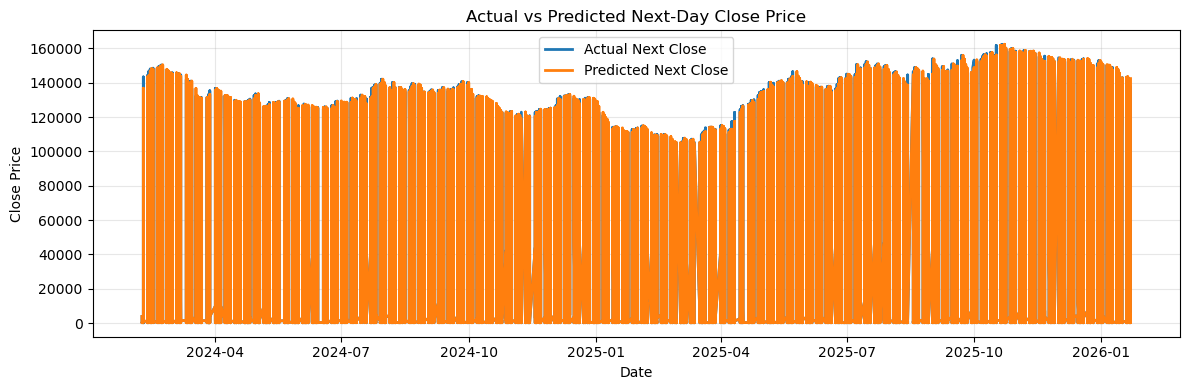

In [14]:
# Actual vs Predicted Close (Line Graph)

plt.figure(figsize=(12, 4))
plt.plot(y_test.index, true_close, label="Actual Next Close", linewidth=2)
plt.plot(y_test.index, pred_close, label="Predicted Next Close", linewidth=2)

plt.title("Actual vs Predicted Next-Day Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


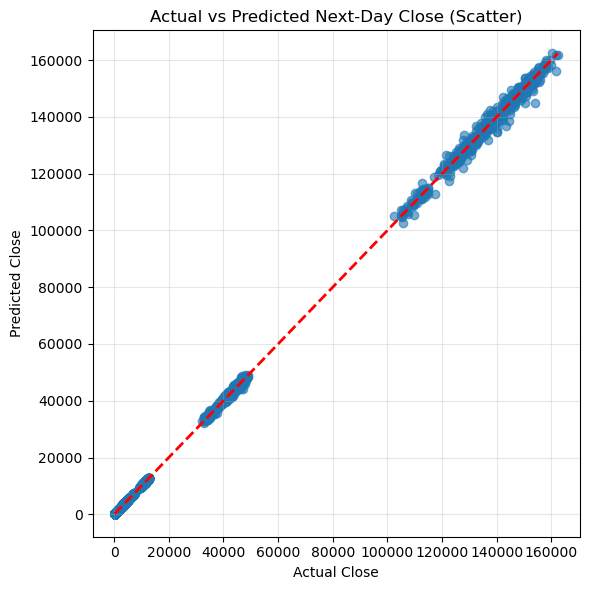

In [15]:
# Scatter Plot: Actual vs Predicted Close

plt.figure(figsize=(6, 6))
plt.scatter(true_close, pred_close, alpha=0.6)

# Perfect prediction line (y = x)
min_val = min(true_close.min(), pred_close.min())
max_val = max(true_close.max(), pred_close.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", linewidth=2, color='red')

plt.title("Actual vs Predicted Next-Day Close (Scatter)")
plt.xlabel("Actual Close")
plt.ylabel("Predicted Close")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


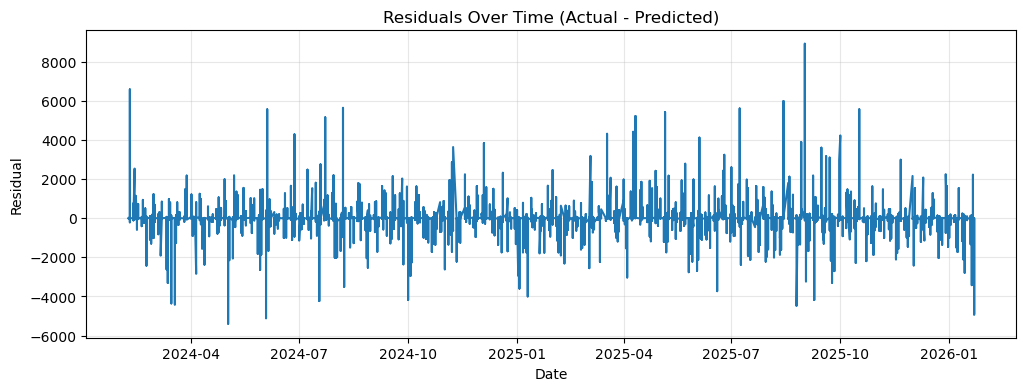

In [16]:
# Cell 14: Residual analysis (price level)

residuals = true_close - pred_close

plt.figure(figsize=(12,4))
plt.plot(y_test.index, residuals)
plt.title("Residuals Over Time (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True, alpha=0.3)
plt.show()



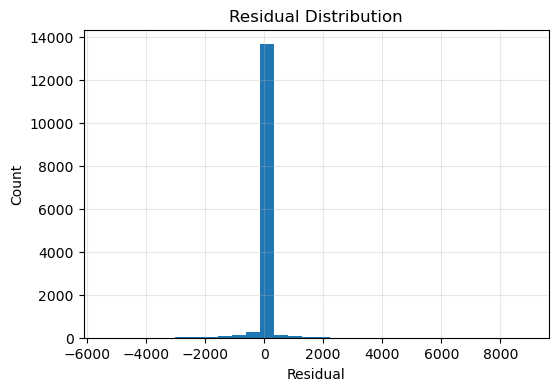

In [17]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()


In [18]:
# Cell 15: Save best universal model and required feature columns

joblib.dump(best_model, "universal_stock_regression_model.pkl")
joblib.dump(list(X.columns), "universal_feature_cols.pkl")

print("Saved deployment files:")
print("universal_stock_regression_model.pkl")
print("universal_feature_cols.pkl")


Saved deployment files:
universal_stock_regression_model.pkl
universal_feature_cols.pkl
